In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo',
                                    dest_path='content/face_mask_detection.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
train=pd.read_csv('/content/content/face_mask_detection/Training_set_face_mask.csv')
train.head(2)

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask


In [5]:
file_paths = [[fname, '/content/content/face_mask_detection/train/' + fname] for fname in train['filename']]

In [6]:
# Confirm if number of images is same as number of labels given
if len(train) == len(file_paths):
    print('Number of labels i.e. ', len(train), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')


Number of labels i.e.  11264 matches the number of filenames i.e.  11264


In [7]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...


In [8]:
train = pd.merge(images, train, how = 'inner', on = 'filename')
train.head()

,filename,filepaths,label
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...,without_mask


In [9]:
data=[]
labels=[]
for i in range(len(train)):
  img_array=cv2.imread(train["filepaths"][i])
  #img_array = tf.cast(img_array, tf.float32)
  #img_array = tf.image.convert_image_dtype(img_array, tf.float32)
  data.append(img_array)
  if train["label"][i]=='without_mask':
    labels.append(0)
  else:
    labels.append(1)

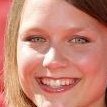

In [10]:
from google.colab.patches import cv2_imshow
cv2_imshow(data[0])

Datasets and images have been loaded to be used in model building

In [16]:
for i in range(len(data)):
  data[i]=cv2.resize(data[i],(128,128))

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test=train_test_split(np.array(data),np.array(labels), random_state=42,stratify=np.array(labels))

In [31]:
image_size = 128
IMG_SHAPE = (image_size, image_size, 3)
mbv2 = MobileNetV2(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
mbv2.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


In [32]:
mbv2_model=Sequential()

In [33]:
mbv2_model.add(mbv2)

In [34]:
mbv2_model.add(GlobalAveragePooling2D())
mbv2_model.add(Dense(2048, activation='relu'))
mbv2_model.add(Dropout(0.6))
mbv2_model.add(Dense(1024, activation='relu'))
mbv2_model.add(Dropout(0.5))
mbv2_model.add(Dense(512, activation='relu'))
mbv2_model.add(Dropout(0.3))
mbv2_model.add(Dense(1024, activation='relu'))
mbv2_model.add(Dropout(0.5))
mbv2_model.add(Dense(1, activation='sigmoid'))

In [35]:
# optimizer
sgd = SGD(lr=0.025)

In [36]:
mbv2_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
mbv2_model.fit(X_train,y_train, epochs=30, verbose=1, validation_split=0.25)

Epoch 1/30
198/198 [==============================] - 4s 21ms/step - loss: 0.4279 - accuracy: 0.8073 - val_loss: 0.3525 - val_accuracy: 0.8750
Epoch 2/30
198/198 [==============================] - 3s 17ms/step - loss: 0.2947 - accuracy: 0.8908 - val_loss: 0.2309 - val_accuracy: 0.9100
Epoch 3/30
198/198 [==============================] - 3s 17ms/step - loss: 0.2606 - accuracy: 0.9010 - val_loss: 0.2115 - val_accuracy: 0.9171
Epoch 4/30
198/198 [==============================] - 3s 17ms/step - loss: 0.2373 - accuracy: 0.9110 - val_loss: 0.2023 - val_accuracy: 0.9233
Epoch 5/30
198/198 [==============================] - 3s 17ms/step - loss: 0.2216 - accuracy: 0.9176 - val_loss: 0.2009 - val_accuracy: 0.9238
Epoch 6/30
198/198 [==============================] - 3s 17ms/step - loss: 0.2155 - accuracy: 0.9175 - val_loss: 0.1898 - val_accuracy: 0.9276
Epoch 7/30
198/198 [==============================] - 3s 17ms/step - loss: 0.2057 - accuracy: 0.9216 - val_loss: 0.1920 - val_accuracy: 0.9271

In [38]:
mbv2_model_loss, mbv2_model_acc = mbv2_model.evaluate(X_test,y_test)

88/88 [==============================] - 1s 14ms/step - loss: 0.2309 - accuracy: 0.9197


In [39]:
print('Test accuracy using MobileNetV2 model as the base:', mbv2_model_acc)

Test accuracy using MobileNetV2 model as the base: 0.9197443127632141


In [40]:
test=pd.read_csv('/content/content/face_mask_detection/Testing_set_face_mask.csv')

In [41]:
file_paths = [[fname, '/content/content/face_mask_detection/test/' + fname] for fname in test['filename']]

In [42]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test = pd.merge(images, test, how = 'inner', on = 'filename')
test.head(2)

,filename,filepaths,label
0,Image_1.jpg,/content/content/face_mask_detection/test/Imag...,NaN
1,Image_2.jpg,/content/content/face_mask_detection/test/Imag...,NaN


In [43]:
test_data=[]
for i in range(len(test)):
  img_array=cv2.imread(test["filepaths"][i])
  #img_array = tf.cast(img_array, tf.float32)
  #img_array = tf.image.convert_image_dtype(img_array, tf.float32)
  test_data.append(img_array)

In [45]:
for i in range(len(test_data)):
  test_data[i]=cv2.resize(test_data[i],(128,128))

In [50]:
preds=mbv2_model.predict(np.array(test_data))

In [54]:
predictions=[]
for i in range(preds.shape[0]):
  if preds[i]>=0.5:
    predictions.append('with_mask')
  else:
    predictions.append('without_mask')

In [56]:
res = pd.DataFrame(predictions) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
#res.index = test.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]
res.to_csv("C:\DPhi\Face Mask Detection\prediction_results.csv")

In [57]:
from google.colab import  drive
drive.mount('/drive')

Mounted at /drive


In [58]:
res.to_csv('/drive/My Drive/DPhi/Face_Mask_Detection_predictions/prediction_results.csv')